In [1]:
import pandas as pd
import time
import numpy as np
import os
from collections import defaultdict
from sklearn.decomposition import PCA
from heavy_tail_observations import BothSideWeibullNoise, BothSideParetoNoise, BothSideFrechetNoise
from heavy_tail_lin_bandit import MENU, TOFU, SupHvyLinBandit
from heavy_tail_lin_bandit_emotion_model import MENU_e

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [23]:
data = pd.read_csv("Induced Musical Emotion.csv")
data

,track id,genre,amazement,solemnity,tenderness,nostalgia,calmness,power,joyful_activation,tension,sadness,mood,liked,disliked,age,gender,mother tongue
0,1,classical,0,1,0,0,0,0,1,1,0,3,1,0,21,1,English
1,1,classical,0,0,0,1,0,0,0,0,0,3,0,1,41,1,Dutch
2,1,classical,0,0,0,1,0,0,0,0,1,3,0,0,24,1,English
3,1,classical,0,0,0,0,1,0,0,0,0,3,0,0,32,0,Spanish
4,1,classical,0,0,0,1,1,0,0,0,0,4,0,1,21,0,English
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8402,400,pop,1,1,0,0,0,0,1,0,0,3,0,0,26,1,Russian
8403,400,pop,0,0,0,1,0,0,1,0,1,3,0,1,29,0,Russian
8404,400,pop,0,0,0,0,0,0,0,1,0,4,0,1,34,1,Polish
8405,400,pop,1,0,0,0,0,0,1,1,0,5,0,0,39,1,French


In [24]:
data = data.drop([' amazement', ' solemnity', ' tenderness', ' nostalgia', ' calmness', ' power', ' genre', ' joyful_activation', ' tension', ' sadness', ' mood', ' age', ' gender', ' mother tongue'], axis=1)
data

,track id,liked,disliked
0,1,1,0
1,1,0,1
2,1,0,0
3,1,0,0
4,1,0,1
...,...,...,...
8402,400,0,0
8403,400,0,1
8404,400,0,1
8405,400,0,0


In [25]:
tag_log = pd.read_csv('tags_logi.csv')
tag_log = tag_log.drop(['Unnamed: 0'], axis=1)
tag_log

,track id,genre,mood/theme---action,mood/theme---adventure,mood/theme---advertising,mood/theme---background,mood/theme---ballad,mood/theme---calm,mood/theme---children,mood/theme---christmas,...,mood/theme---slow,mood/theme---soft,mood/theme---soundscape,mood/theme---space,mood/theme---sport,mood/theme---summer,mood/theme---trailer,mood/theme---travel,mood/theme---upbeat,mood/theme---uplifting
0,1,classical,0.002376,0.009213,0.015566,0.019890,0.023473,0.024080,0.005286,0.028980,...,0.025568,0.022343,0.016142,0.012046,0.001952,0.002078,0.000576,0.004674,0.002128,0.010974
1,2,classical,0.005639,0.012651,0.012793,0.012798,0.003338,0.015878,0.001955,0.011217,...,0.008247,0.006880,0.026790,0.027412,0.001851,0.001136,0.001627,0.003926,0.001033,0.005437
2,3,classical,0.009581,0.010186,0.011635,0.011774,0.002394,0.003691,0.001225,0.005851,...,0.003500,0.002091,0.011797,0.012227,0.017147,0.002807,0.001697,0.002689,0.007608,0.012187
3,4,classical,0.001265,0.005613,0.013116,0.026640,0.005549,0.013257,0.004866,0.012068,...,0.001037,0.013048,0.003450,0.003030,0.000987,0.000811,0.000232,0.002147,0.001003,0.008989
4,5,classical,0.006248,0.011197,0.012326,0.018698,0.006294,0.012258,0.002509,0.011082,...,0.007521,0.008100,0.012973,0.009666,0.001405,0.000314,0.001883,0.002778,0.000643,0.005982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,396,pop,0.003901,0.014806,0.029541,0.048577,0.030159,0.028118,0.010944,0.069093,...,0.009544,0.031977,0.010732,0.007031,0.002800,0.001677,0.001044,0.006551,0.005530,0.026672
396,397,pop,0.002580,0.004813,0.007780,0.007547,0.000757,0.003163,0.000708,0.004280,...,0.004606,0.001559,0.006756,0.007236,0.004021,0.000855,0.000477,0.001305,0.001221,0.004746
397,398,pop,0.002637,0.009449,0.028664,0.015163,0.001700,0.003020,0.007568,0.012569,...,0.001044,0.001939,0.002037,0.002112,0.021801,0.008542,0.000405,0.001731,0.043691,0.063805
398,399,pop,0.004715,0.008978,0.009029,0.017335,0.004001,0.017538,0.000733,0.006374,...,0.005790,0.010386,0.035687,0.029996,0.001294,0.001170,0.001263,0.005052,0.000963,0.004665


In [26]:
d = pd.merge(data, tag_log, on='track id', how='left')
d = d[:8400]
d

,track id,liked,disliked,genre,mood/theme---action,mood/theme---adventure,mood/theme---advertising,mood/theme---background,mood/theme---ballad,mood/theme---calm,...,mood/theme---slow,mood/theme---soft,mood/theme---soundscape,mood/theme---space,mood/theme---sport,mood/theme---summer,mood/theme---trailer,mood/theme---travel,mood/theme---upbeat,mood/theme---uplifting
0,1,1,0,classical,0.002376,0.009213,0.015566,0.019890,0.023473,0.024080,...,0.025568,0.022343,0.016142,0.012046,0.001952,0.002078,0.000576,0.004674,0.002128,0.010974
1,1,0,1,classical,0.002376,0.009213,0.015566,0.019890,0.023473,0.024080,...,0.025568,0.022343,0.016142,0.012046,0.001952,0.002078,0.000576,0.004674,0.002128,0.010974
2,1,0,0,classical,0.002376,0.009213,0.015566,0.019890,0.023473,0.024080,...,0.025568,0.022343,0.016142,0.012046,0.001952,0.002078,0.000576,0.004674,0.002128,0.010974
3,1,0,0,classical,0.002376,0.009213,0.015566,0.019890,0.023473,0.024080,...,0.025568,0.022343,0.016142,0.012046,0.001952,0.002078,0.000576,0.004674,0.002128,0.010974
4,1,0,1,classical,0.002376,0.009213,0.015566,0.019890,0.023473,0.024080,...,0.025568,0.022343,0.016142,0.012046,0.001952,0.002078,0.000576,0.004674,0.002128,0.010974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8395,400,0,1,pop,0.003504,0.014973,0.016813,0.026609,0.017590,0.026296,...,0.003307,0.030166,0.012690,0.008786,0.001848,0.001653,0.000754,0.005312,0.002416,0.012740
8396,400,0,0,pop,0.003504,0.014973,0.016813,0.026609,0.017590,0.026296,...,0.003307,0.030166,0.012690,0.008786,0.001848,0.001653,0.000754,0.005312,0.002416,0.012740
8397,400,0,0,pop,0.003504,0.014973,0.016813,0.026609,0.017590,0.026296,...,0.003307,0.030166,0.012690,0.008786,0.001848,0.001653,0.000754,0.005312,0.002416,0.012740
8398,400,1,0,pop,0.003504,0.014973,0.016813,0.026609,0.017590,0.026296,...,0.003307,0.030166,0.012690,0.008786,0.001848,0.001653,0.000754,0.005312,0.002416,0.012740


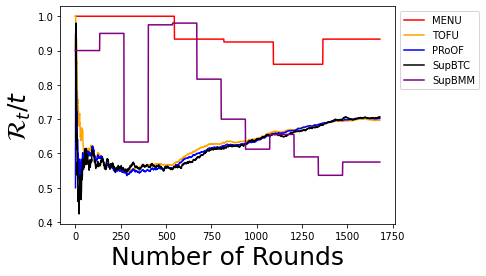

<Figure size 1440x1080 with 0 Axes>

In [28]:
iter = 0
err = np.zeros((5, 1680))
while(iter < 10):
    df = d.sample(frac=1)
    df2 = df.drop(['track id', ' liked', ' disliked', ' genre'], axis=1)

    y1 = d[' liked'].to_numpy()
    y2 = d[' disliked'].to_numpy()
    y = y1 + (-1 * y2)

    X = df2.to_numpy()
    dim = X.shape[1]
    total_samples = len(y)

    T = 1680
    K = int(total_samples/T)

    p = 1.5
    S = 1.

    D = np.reshape(X, (T,K,dim))
    R = np.reshape(y, (T,K))
    
    get_mean = lambda x, y: R[y]
    get_observation = lambda x, y, z: R[y][z]
    
    error_list, theta_star = MENU(D, get_mean, get_observation, S=S, lamb=1., delta=0.01, p=p, c=1.)
    err[0][:] += error_list
    
    error_list, theta_star = TOFU(D, get_mean, get_observation, S=S, lamb=1., delta=0.01, p=p, b=1.)
    err[1][:] += error_list
    
    error_list, pro_estimator = SupHvyLinBandit(D, get_mean, get_observation, method="proof", S=S, lamb=1., delta=0.001, nu = 1e-4, p=p)
    err[2][:] += error_list
    
    error_list, btc_estimator = SupHvyLinBandit(D, get_mean, get_observation, method="btc", S=S, lamb=1., delta=0.001, nu = 1., p=p)
    err[3][:] += error_list
    
    error_list, bmm_estimator = SupHvyLinBandit(D, get_mean, get_observation, method="bmm", S=S, lamb=1., delta=0.001, nu = 1., p=p)
    err[4][:] += error_list
    
    
    #plt.plot(error_list)

    iter += 1
err /= 10
plt.plot(err[0], color='red', label='MENU')
plt.plot(err[1], color='orange', label='TOFU')
plt.plot(err[2], color='blue', label='PRoOF')
plt.plot(err[3], color='black', label='SupBTC')
plt.plot(err[4], color='purple', label='SupBMM')

plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel("Number of Rounds",fontsize=25)
plt.ylabel("$\mathcal{R}_{t}/t$ ",fontsize=25)
plt.figure(figsize=(20,15))
plt.show()